# 1. Packages

In [20]:
import pandas as pd
import pyarrow
import fastparquet
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from joblib import Parallel, delayed
from sklearn.metrics import classification_report, accuracy_score, precision_score
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# 2. Data

In [5]:
os.chdir('/Users/clemenspaulsen/Desktop/May24_BDS_INT_Fire_Brigade/data')
df = pd.read_parquet('df_cleaned_for_classification_models.parquet')

target = df['ResponseTimeBinary']
features = df.drop(columns=['ResponseTimeBinary'])

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=666)

# 3. XGBoost

In [8]:
# Step 1: Apply PCA
pca = PCA(n_components=0.85)  # Retain 85% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [12]:
# Step 2: Under-sample the majority class
rus = RandomUnderSampler(random_state=123)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_pca, y_train)


In [16]:
# Step 3: Build and tune XGBoost model using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9]
}

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False)
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train_resampled, y_train_resampled)

best_model = grid_search.best_estimator_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:54:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:54:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:54:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:54:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packa

In [24]:
# Print the best hyperparameters
print("Best Hyperparameters:")
print(grid_search.best_params_)

Best Hyperparameters:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}


Train Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.63      0.66    361454
           1       0.66      0.73      0.70    361454

    accuracy                           0.68    722908
   macro avg       0.68      0.68      0.68    722908
weighted avg       0.68      0.68      0.68    722908

Train ROC-AUC Score: 0.746976519906083

Test Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.62      0.55     90243
           1       0.82      0.73      0.77    217298

    accuracy                           0.70    307541
   macro avg       0.66      0.68      0.66    307541
weighted avg       0.73      0.70      0.71    307541

Test ROC-AUC Score: 0.7410707514722088


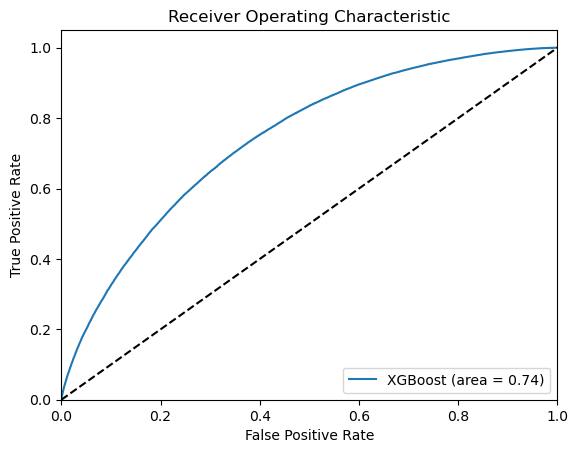

In [22]:
# Step 4: Evaluate the model
# Train set evaluation
y_train_pred = best_model.predict(X_train_resampled)
y_train_prob = best_model.predict_proba(X_train_resampled)[:, 1]

print("Train Classification Report:")
print(classification_report(y_train_resampled, y_train_pred))
print("Train ROC-AUC Score:", roc_auc_score(y_train_resampled, y_train_prob))

# Test set evaluation
y_test_pred = best_model.predict(X_test_pca)
y_test_prob = best_model.predict_proba(X_test_pca)[:, 1]

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Test ROC-AUC Score:", roc_auc_score(y_test, y_test_prob))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % roc_auc_score(y_test, y_test_prob))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()